In [24]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\final_dataset.csv")

# Rename the column
df.rename(columns={'0': 'recipeID'}, inplace=True)

df = df[['recipeID', 'instructions', 'ingredients_no_quantities']]

df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\891_instructions_dataset.csv")
df.head()

,recipeID,instructions,ingredients_no_quantities
0,1,add all the ingredients for the sauces into a ...,"['gochujang base', 'ketchup', 'maple syrup', '..."
1,2,start by trimming any woody ends from the aspa...,"['asparagus', 'butter', 'egg', 'sourdough', 'w..."
2,3,preheat the oven to 180°c fan. wash the potato...,"['puff pastry', 'potatoes', 'leeks', 'garlic',..."
3,4,"finely chop the bacon, spring onions, chilli, ...","['streaky bacon', 'spring onions', 'chilli', '..."
4,5,preheat the oven to 200°c.\nline a baking tray...,"['pork belly', 'maple syrup', 'cider vinegar',..."


## Apply different normalization methods

In [20]:
import pandas as pd
import unicodedata

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\891_instructions_dataset.csv")

# Function to convert string to list of strings
def string_to_list(instruction):
    return instruction.split('. ')
    

# Function to split each sentence by period while maintaining the original list structure
def split_instructions(instructions):
    if pd.isnull(instructions):
        return instructions
    # Convert the string representation of the list into an actual list
    instruction_list = eval(instructions) if isinstance(instructions, str) else instructions
    # Split each step by periods and flatten the resulting list
    split_items = []
    for step in instruction_list:
        split_items.extend([item.strip() for item in step.split('.') if item.strip()])
    return split_items

# Function to remove accents
def remove_accents(text):
    normalized_text = unicodedata.normalize('NFKD', text)
    return ''.join(c for c in normalized_text if not unicodedata.combining(c))


# Apply function to each row in DataFrame
df['instructions'] = df['instructions'].apply(string_to_list).apply(clean_and_split_instructions).apply(lambda x: [remove_accents(item.lower()) for item in x] if isinstance(x, list) else x)

df['ingredients_no_quantities'] = df['ingredients_no_quantities'].apply(lambda x: [remove_accents(item.lower()) for item in x] if isinstance(x, list) else x)


# Print DataFrame with new column
df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\891_instructions_dataset.csv")
df.head()

,Unnamed: 0,recipeID,instructions,ingredients_no_quantities
0,0,1,[add all the ingredients for the sauces into a...,"['gochujang base', 'ketchup', 'maple syrup', '..."
1,1,2,[start by trimming any woody ends from the asp...,"['asparagus', 'butter', 'egg', 'sourdough', 'w..."
2,2,3,"[preheat the oven to 180°c fan, wash the potat...","['puff pastry', 'potatoes', 'leeks', 'garlic',..."
3,3,4,"[finely chop the bacon, spring onions, chilli,...","['streaky bacon', 'spring onions', 'chilli', '..."
4,4,5,"[preheat the oven to 200°c, line a baking tray...","['pork belly', 'maple syrup', 'cider vinegar',..."


## FLAN T-5 First Prompt (After normalization)

In [1]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import ast

# Load the dataset (recipe instructions dataset)
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\891_instructions_dataset.csv")

# Ensure ingredients column is a list if it is a string representation of a list
if isinstance(df['ingredients_no_quantities'][0], str):
    df['ingredients_no_quantities'] = df['ingredients_no_quantities'].apply(ast.literal_eval)

# Convert the steps column to actual list from string representation
df['instructions'] = df['instructions'].apply(ast.literal_eval)

# Load the model and tokenizer
model_name = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Function to extract ingredients from a single instruction using LLM
def llm_ingredient_extraction(instruction):
    prompt = f"Extract the ingredient(s) mentioned in the following recipe instruction. Do not include quantities, units, or any additional descriptions, just the core name of the ingredient(s). Be precise and concise. For the instruction: '{instruction}', the ingredient(s) are:"
    inputs = tokenizer(prompt, return_tensors="pt")
    
    # Generate prediction for the instruction
    outputs = model.generate(**inputs)
    
    # Decode the output for the instruction
    extracted_ingredient = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return extracted_ingredient

# Function to process recipe steps and extract ingredients
def process_recipe_steps(row):
    instructions = row['instructions']  # List of recipe instructions (steps)
    ground_truth = row['ingredients_no_quantities']  # List of ingredients
    
    extracted_ingredients = []
    
    # Process each instruction individually
    for instruction in instructions:
        # Extract ingredient from the instruction
        extracted_ingredient = llm_ingredient_extraction(instruction)
        
        # Add the extracted ingredient to the list
        extracted_ingredients.append(extracted_ingredient)
    
    return {
        "recipeID": row['recipeID'],
        "instructions": row['instructions'],
        "extracted_ingredients": extracted_ingredients,
        "ground_truth": ground_truth
    }

# Apply the function to each row to extract ingredients from the instructions
df['extracted_ingredients'] = df.apply(process_recipe_steps, axis=1)

# Convert the results into a new DataFrame
detailed_df = pd.DataFrame(df['extracted_ingredients'].tolist())

# Save the detailed results to a CSV file
detailed_df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\extracted_instructions.csv", index=False)

# Print a preview of the results
print(detailed_df.head())

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
C:\Users\teore\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\teore\Lib\site-packages\transformers\generation\utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the gen

   recipeID                                       instructions  \
0         1  [add all the ingredients for the sauces into a...   
1         2  [start by trimming any woody ends from the asp...   
2         3  [preheat the oven to 180°c fan, wash the potat...   
3         4  [finely chop the bacon, spring onions, chilli,...   
4         5  [preheat the oven to 200°c, line a baking tray...   

                               extracted_ingredients  \
0  [sour cream, ginger, chicken, eggs, corn flour...   
1  [asparagus, stem, brown butter, milk, hazelnut...   
2  [fan, potatoes, leeks, garlic, potatoes, olive...   
3  [bacon, spring onions, chilli, carrot and wate...   
4  [oven, pork belly, salt, maple syrup, vinegar,...   

                                        ground_truth  
0  [gochujang base, ketchup, maple syrup, soy sau...  
1  [asparagus, butter, egg, sourdough, wine vineg...  
2  [puff pastry, potatoes, leeks, garlic, oat fra...  
3  [streaky bacon, spring onions, chilli, carr

## Strict Match Count

In [5]:
import pandas as pd
import os


# # Rename files for easier understanding (DO IT ONCE!)
# old_file_path = r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\extracted_instructions.csv"
# new_file_path = r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\extracted_instructions_pca.csv"
# os.rename(old_file_path, new_file_path)

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\extracted_instructions_pca.csv")

# Ensure ground truth is a list
df['ground_truth'] = df['ground_truth'].str.lower().apply(eval)  # Convert string representation to list
df['extracted_ingredients'] = df['extracted_ingredients'].str.lower().apply(eval)  # Convert to lowercase


# Function to split elements followed by a comma and add them to the list (this happened during extraction)
def split_ingredients(ingredients):
    new_ingredients = []
    for ingredient in ingredients:
        if (',' in ingredient):
            split_items = [item.strip() for item in ingredient.split(',')]
            new_ingredients.extend(split_items)
        if (';' in ingredient):
            split_items = [item.strip() for item in ingredient.split(';')]
            new_ingredients.extend(split_items)
        if (' and ' in ingredient):
            split_items = [item.strip() for item in ingredient.split(' and ')]
            new_ingredients.extend(split_items)
        else:
            new_ingredients.append(ingredient)
    return new_ingredients


# Function to remove duplicates and empty strings from a list
def remove_duplicates_and_empty(ingredients):
    return list(set(filter(None, ingredients)))

# Apply functions to each row in DataFrame
df['extracted_ingredients'] = df['extracted_ingredients'].apply(split_ingredients).apply(remove_duplicates_and_empty)
df['ground_truth'] = df['ground_truth'].apply(split_ingredients).apply(remove_duplicates_and_empty)


def check_strict_ingredients_in_ground_truth(row):
    """
    Strictly check if each ingredient in the extracted list matches exactly with an ingredient in the ground truth.
    """
    counter = 0
    unique_extracted_ingredients = set(row['extracted_ingredients'])  # Remove duplicates
    matches = []
    for ingredient in unique_extracted_ingredients:
        if ingredient in row['ground_truth']:
            counter += 1
            matches.append((ingredient, ingredient))
    # Calculate percentage of correct matches
    percentage = (counter / len(row['ground_truth'])) * 100 if len(row['ground_truth']) > 0 else 0
    return percentage, matches


#Once we have the matches in a new column, we sum the matches accross all rows and divide it by the total ingredients in the ground truth.
def calculate_overall_match_percentage(df, match_column, ground_truth_column):
    """
    Calculate the overall match percentage across all rows.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        match_column (str): Column name containing tuples (matches).
        ground_truth_column (str): Column name containing ground truth ingredients (lists).

    Returns:
        float: Overall match percentage.
    """
    total_matches = 0
    total_ground_truth_ingredients = 0

    for _, row in df.iterrows():
        # Count matches (number of tuples in the match column)
        total_matches += len(row[match_column])
        
        # Count the number of ground truth ingredients
        total_ground_truth_ingredients += len(row[ground_truth_column])

    # Calculate overall match percentage
    overall_percentage = (total_matches / total_ground_truth_ingredients) * 100 if total_ground_truth_ingredients > 0 else 0
    return overall_percentage

# Apply the function to each row in the DataFrame and extract matches
results = df.apply(check_strict_ingredients_in_ground_truth, axis=1, result_type='expand')
df['matched_ingredients_percentage'] = results[0]
df['matches'] = results[1]

# Calculate the average percentage for each recipe
recipe_percentage = df['matched_ingredients_percentage'].mean()
print(f"Recipe Percentage: {recipe_percentage:.2f}%")

overall_percentage = calculate_overall_match_percentage(df, match_column='matches', ground_truth_column='ground_truth')
print(f"Overall Percentage: {overall_percentage:.2f}%")

# # Save the DataFrame with the new column to a CSV file
df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\extracted_instructions_strict_pca.csv", index=False)

Recipe Percentage: 55.53%
Overall Percentage: 54.95%


## Loose Match Accuracy

In [6]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\extracted_instructions_pca.csv")

# Ensure ground truth is a list
df['ground_truth'] = df['ground_truth'].str.lower().apply(eval)  # Convert string representation to list
df['extracted_ingredients'] = df['extracted_ingredients'].str.lower().apply(eval)  # Convert to lowercase

# Function to remove duplicates and empty strings from a list
def remove_duplicates_and_empty(ingredients):
    return list(set(filter(None, ingredients)))

# Function to split elements followed by a comma and add them to the list (this happened during extraction)
def split_ingredients(ingredients):
    new_ingredients = []
    for ingredient in ingredients:
        if (',' in ingredient):
            split_items = [item.strip() for item in ingredient.split(',')]
            new_ingredients.extend(split_items)
        elif (';' in ingredient):
            split_items = [item.strip() for item in ingredient.split(';')]
            new_ingredients.extend(split_items)
        elif ('and' in ingredient):
            split_items = [item.strip() for item in ingredient.split('and')]
            new_ingredients.extend(split_items)
        else:
            new_ingredients.append(ingredient)
    return new_ingredients

# Function to check if each ingredient in the merged list is a subset of an element in the ground truth or vice versa and calculate percentage
def check_ingredients_in_ground_truth(row):
    """
    Check if each ingredient in the merged list is a subset of an element in the ground truth or vice versa and calculate percentage.
    """
    counter = 0
    unique_extracted_ingredients = set(row['extracted_ingredients'])  # Remove duplicates
    ground_truth_matched = set()
    matches = []
    for ingredient in unique_extracted_ingredients:
        for truth in row['ground_truth']:
            if truth in ground_truth_matched:
                continue
            # First, check for subset match (loose matching)
            if ingredient in truth or truth in ingredient:
                counter += 1
                ground_truth_matched.add(truth)  # Mark this ground truth as matched
                matches.append((ingredient, truth))
                break
    # Calculate percentage of correct matches
    percentage = (counter / len(row['ground_truth'])) * 100 if len(row['ground_truth']) > 0 else 0
    return percentage, matches

# Apply the function to each row in the DataFrame and extract matches
df['extracted_ingredients'] = df['extracted_ingredients'].apply(split_ingredients).apply(remove_duplicates_and_empty)
df['ground_truth'] = df['ground_truth'].apply(split_ingredients).apply(remove_duplicates_and_empty)

# Apply the function to each row in the DataFrame and extract matches
results = df.apply(check_ingredients_in_ground_truth, axis=1, result_type='expand')
df['matched_ingredients_percentage'] = results[0]
df['matches'] = results[1]

# Calculate the average percentage for each recipe
recipe_percentage = df['matched_ingredients_percentage'].mean()
print(f"Recipe Percentage: {recipe_percentage:.2f}%")

overall_percentage = calculate_overall_match_percentage(df, match_column='matches', ground_truth_column='ground_truth')
print(f"Overall Percentage: {overall_percentage:.2f}%")

# # Save the DataFrame with the new column to a CSV file
df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\extracted_instructions_loose_pca.csv", index=False)

Recipe Percentage: 71.89%
Overall Percentage: 71.16%


# Double checked Loose Matching

In [7]:
import pandas as pd
from Levenshtein import distance

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\extracted_instructions_pca.csv")

# Ensure ground truth is a list
df['ground_truth'] = df['ground_truth'].str.lower().apply(eval)  # Convert string representation to list
df['extracted_ingredients'] = df['extracted_ingredients'].str.lower().apply(eval)  # Convert to lowercase


# Function to split elements followed by a comma and add them to the list (this happened during extraction)
def split_ingredients(ingredients):
    new_ingredients = []
    for ingredient in ingredients:
        if (',' in ingredient):
            split_items = [item.strip() for item in ingredient.split(',')]
            new_ingredients.extend(split_items)
        elif (';' in ingredient):
            split_items = [item.strip() for item in ingredient.split(';')]
            new_ingredients.extend(split_items)
        elif ('and' in ingredient):
            split_items = [item.strip() for item in ingredient.split('and')]
            new_ingredients.extend(split_items)
        else:
            new_ingredients.append(ingredient)
    return new_ingredients


# Function to remove duplicates and empty strings from a list
def remove_duplicates_and_empty(ingredients):
    return list(set(filter(None, ingredients)))


# Similarity Functions
def normalized_levenshtein_similarity(s1, s2):
    max_len = max(len(s1), len(s2))
    if max_len == 0:
        return 1.0
    return 1 - distance(s1, s2) / max_len

def jaccard_similarity(s1, s2):
    set1 = set(s1.split())
    set2 = set(s2.split())
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    if union == 0:
        return 0.0
    return intersection / union


# Function to check ingredients, first checking for subset match, then Jaccard, then Levenshtein
def check_ingredients_in_ground_truth(row, jaccard_threshold=0.5, levenshtein_threshold=0.8):
    counter = 0
    unique_extracted_ingredients = set(row['extracted_ingredients'])  # Remove duplicates
    ground_truth_matched = set()
    matches = []
    for ingredient in unique_extracted_ingredients:
        for truth in row['ground_truth']:
            if truth in ground_truth_matched:
                continue
            # First, check for subset match (loose matching)
            if ingredient in truth or truth in ingredient:
                counter += 1
                ground_truth_matched.add(truth)  # Mark this ground truth as matched
                matches.append((ingredient, truth))
                break

            # If no subset match, check for Jaccard similarity
            if jaccard_similarity(ingredient, truth) >= jaccard_threshold:
                counter += 1
                ground_truth_matched.add(truth)  # Mark this ground truth as matched
                matches.append((ingredient, truth))
                break

            #If no Jaccard match, check for Levenshtein similarity
            if normalized_levenshtein_similarity(ingredient, truth) >= levenshtein_threshold:
                counter += 1
                ground_truth_matched.add(truth)  # Mark this ground truth as matched
                matches.append((ingredient, truth))
                break

            

    # Calculate percentage of correct matches
    percentage = (counter / len(row['ground_truth'])) * 100 if len(row['ground_truth']) > 0 else 0
    return percentage, matches


# Apply the function to each row in the DataFrame and extract matches
df['extracted_ingredients'] = df['extracted_ingredients'].apply(split_ingredients).apply(remove_duplicates_and_empty)
df['ground_truth'] = df['ground_truth'].apply(split_ingredients).apply(remove_duplicates_and_empty)

results = df.apply(check_ingredients_in_ground_truth, axis=1, result_type='expand')
df['matched_ingredients_percentage'] = results[0]
df['matches'] = results[1]

# Calculate the average percentage for each recipe
recipe_percentage = df['matched_ingredients_percentage'].mean()
print(f"Recipe Percentage: {recipe_percentage:.2f}%")

overall_percentage = calculate_overall_match_percentage(df, match_column='matches', ground_truth_column='ground_truth')
print(f"Overall Percentage: {overall_percentage:.2f}%")

# Save the DataFrame with the new column to a CSV file
df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\extracted_instructions_checked_loose_pca.csv", index=False)

Recipe Percentage: 72.18%
Overall Percentage: 71.44%


## Strict Matching Plot

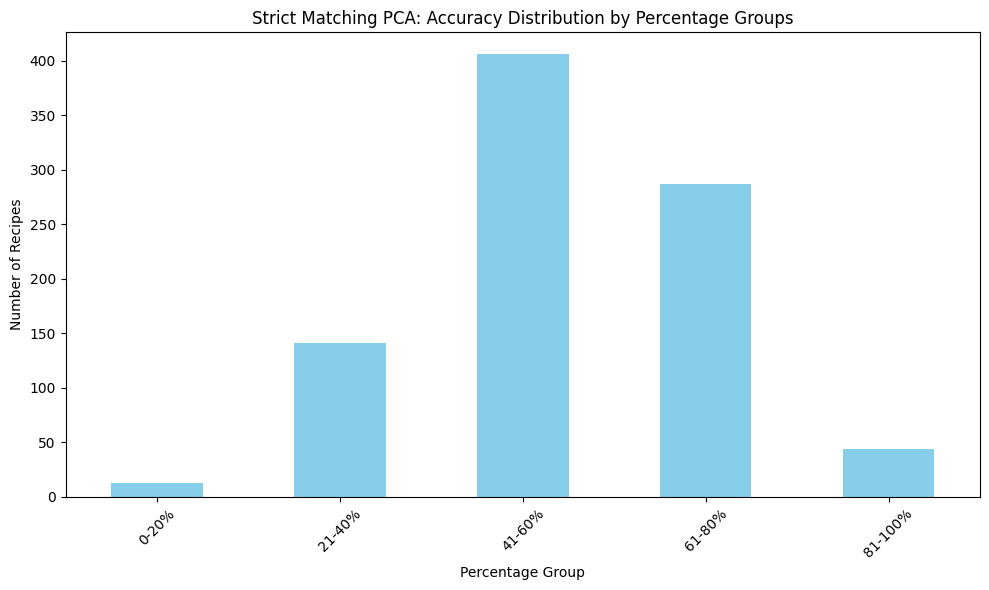

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\extracted_instructions_strict_pca.csv")

# Define percentage groups
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']

# Create a new column for percentage groups
df['percentage_group'] = pd.cut(df['matched_ingredients_percentage'], bins=bins, labels=labels, include_lowest=True)

# Plot the distribution of percentage groups
plt.figure(figsize=(10, 6))
df['percentage_group'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Strict Matching PCA: Accuracy Distribution by Percentage Groups')
plt.xlabel('Percentage Group')
plt.ylabel('Number of Recipes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\PCA_percentage_distribution_strict.png")
plt.show()


## Loose Matching Plot

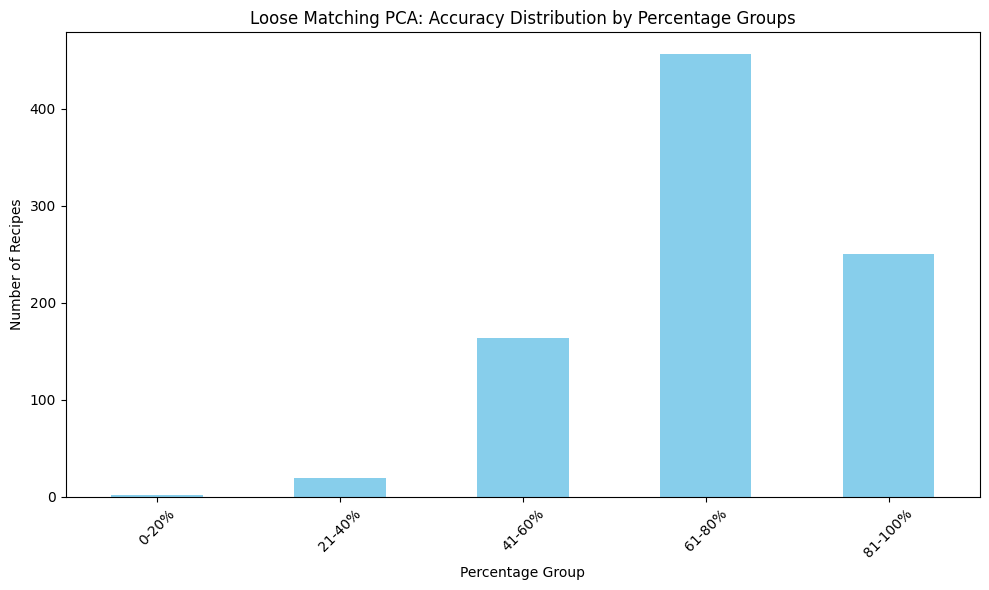

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\extracted_instructions_loose_pca.csv")

# Define percentage groups
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']

# Create a new column for percentage groups
df['percentage_group'] = pd.cut(df['matched_ingredients_percentage'], bins=bins, labels=labels, include_lowest=True)

# Plot the distribution of percentage groups
plt.figure(figsize=(10, 6))
df['percentage_group'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Loose Matching PCA: Accuracy Distribution by Percentage Groups')
plt.xlabel('Percentage Group')
plt.ylabel('Number of Recipes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\PCA_percentage_distribution_loose.png")
plt.show()


## Checked Loose Matching Plot

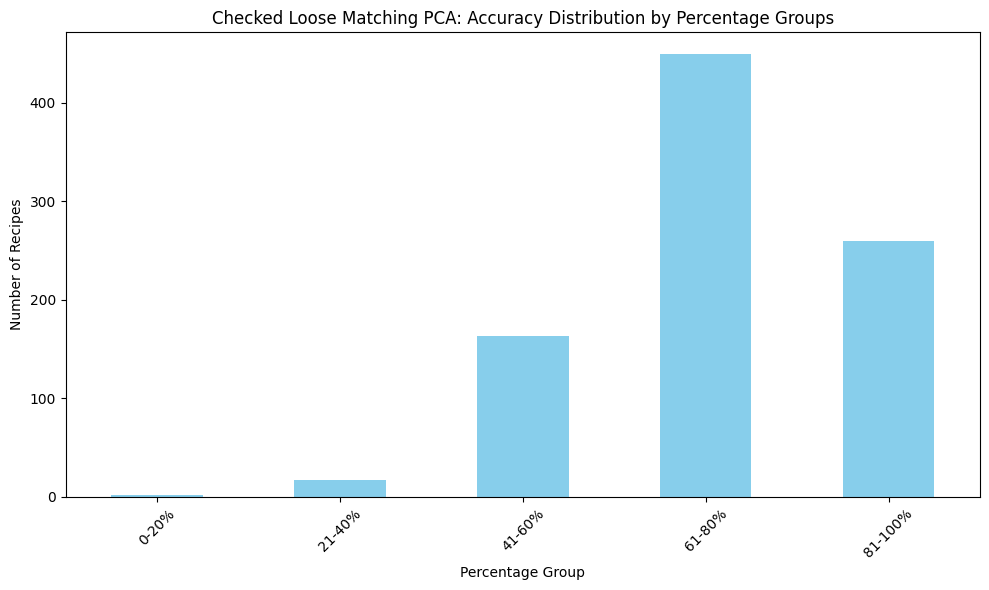

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\extracted_instructions_checked_loose_pca.csv")

# Define percentage groups
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']

# Create a new column for percentage groups
df['percentage_group'] = pd.cut(df['matched_ingredients_percentage'], bins=bins, labels=labels, include_lowest=True)

# Plot the distribution of percentage groups
plt.figure(figsize=(10, 6))
df['percentage_group'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Checked Loose Matching PCA: Accuracy Distribution by Percentage Groups')
plt.xlabel('Percentage Group')
plt.ylabel('Number of Recipes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\ri_pca_distribution_checked_loose.png")
plt.show()
